<h1 align='center'>Final assignment of "Management and Analysis of Physics Datasets"</h1>
<img align='right' src='https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova.png' alt='Drawing' style='width:400px;'/>


<h2 align='left'>Setting an upper limit on the branching ratio of FCNC $t\bar{t}$ processes with CMS data: a distributed approach</h2>


<h3 align='left'>University of Padua - Physics of Data</h3>
<h4 align='left'>Prof. Jacopo Pazzini</h4>
<br>

**Name** | **ID number** | **mail**@studenti.unipd.it
:-:|:-:|-:
Chiara Maccani | 2027591 | chiara.maccani
Samuele Piccinelli | 2027650 | samuele.piccinelli
Tommaso Stentella | 2027586 | tommaso.stentella
Cristina Venturini | 2022461 | cristina.venturini.5

<a id='index'></a>
### Index

#### 1. [Setting up the Spark session](#1)
#### 2. [Read the ROOT files stored remotely from S3 bucket¶](#2)
#### 3. [Path and dataset](#3)
#### 4. [Read and load the data](#4)
#### 5. [Measuring performance](#5)
#### 6. [Skimming and HLF creation](#6)
#### 7. [Save the datasets as parquet files](#7)
#### 8. [Histograms plotting](#8)
#### 9. [Statistical analysis](#9)
#### 10. [Final results](#10)

In [1]:
# - import libraries and useful dependencies

import numpy as np
import math as mh
import uproot
import requests
import ssl
import seaborn as sns
import json
import pandas as pd

import findspark
findspark.init('/usr/local/spark')

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.lines import Line2D

plt.rc('axes', **{'grid':False,'titlesize':'large','labelsize':'large','unicode_minus':False})
plt.rc('legend',fontsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

<a id='1'></a>
[Index](#index)
### 1. Setting up the Spark session

In [2]:
%%capture

spark = SparkSession.builder \
        .master('spark://10.67.22.59:7077') \
        .appName('MAPD-B Exam') \
        .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:2.7.3,ch.cern.sparkmeasure:spark-measure_2.12:0.17') \
        .config('spark.executor.cores', '4') \
        .config('spark.executor.memory','6g') \
        .getOrCreate()

In [3]:
spark

In [4]:
sc = spark.sparkContext

<a id='2'></a>
[Index](#index)
### 2. Read the ROOT files stored remotely from S3 bucket

In [5]:
import os
import configparser

config = configparser.ConfigParser()
config.read(os.path.expanduser('~/.s3cfg'))
access_id = config.get('aws_profile', 'access_key') 
access_key = config.get('aws_profile', 'secret_key')

In [6]:
hadoop_conf=sc._jsc.hadoopConfiguration()

hadoop_conf.set('fs.s3n.impl', 'org.apache.hadoop.fs.s3native.NativeS3FileSystem')
hadoop_conf.set('fs.s3n.awsAccessKeyId', access_id)
hadoop_conf.set('fs.s3n.awsSecretAccessKey', access_key)

<a id='3'></a>
[Index](#index)
### 3. Path and dataset

In [7]:
%%capture

buck = 'https://cloud-areapd.pd.infn.it:5210/swift/v1/AUTH_d2e941ce4b324467b6b3d467a923a9bc/LCPmodB-Y3_CMS_FCNC/'

listDir = requests.get(buck, verify=False).text.split('\n')
# listDir

In [8]:
def returnDir(string):
    return [filename for filename in listDir if filename.startswith(string)]

In [9]:
# - Data + MC Signal
dataDirs = returnDir('SingleMuon')
for i in range(len(dataDirs)):
    dataDirs[i] = [buck + dataDirs[i], 'data']

signalMCDirs = returnDir('TT_FCNC')
for i in range(len(signalMCDirs)):
    signalMCDirs[i] = [buck + signalMCDirs[i], 'signal']

# - MC backgrounds
listBkgDir = ['ST_', 'TTTT_Tune', 'TTTo2L2Nu', 'TTToHadronic', 'TTToSemiLeptonic', 'TTWJetsToLNu', 'TTZToLLNuNu',
              'WGToLNuG', 'WJetsToLNu', 'WWTo2L2Nu', 'WWW', 'WWZ', 'WZG', 'WZTo1L1Nu2Q', 'WZTo2L2Q', 'WZTo3LNu',
              'WZZ', 'WmWmJJ', 'WminusH', 'WpWpJJ', 'ZG', 'ZZ', 'tZq', 'DYJetsToLL_M', 'QCD']

bkgMCDirs = list(map(returnDir, listBkgDir))

bkgFiles = []
for j,i in zip(listBkgDir, bkgMCDirs):
    for k in i:
        bkgFiles.append([buck + k, j])

# 1/3 of the dataset is here used
fileList = dataDirs[::3] + signalMCDirs[::3] + bkgFiles[::3]

<a id='4'></a>
[Index](#index)
### 4. Read and load the data

In [10]:
def readRoot(file_label):
    if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
        ssl._create_default_https_context = ssl._create_unverified_context
        
    file_name = file_label[0]
    label = file_label[1]
    
    var = ['iSkim', 'event', 'eventWeightLumi', 'nMuon','Muon_pfRelIso03_all', 'Muon_pt', 'Muon_eta',
            'Muon_phi', 'Muon_charge', 'nElectron','Electron_pfRelIso03_all','nCleanJet','nBJet','MET_pt', 'MET_phi']

    pro = uproot.open(file_name + ':Events').arrays(var, library='np')
    nEvent = len(pro['event'])
    custom_data = [0 for _ in range(nEvent)]

    for i in range(nEvent):
        event = dict(list(zip(var, [pro[j][i].tolist() for j in var])))
        event['sample'] = label
        custom_data[i] = event
    return custom_data

In [11]:
# load data
dfRoot = sc.parallelize(fileList)\
           .flatMap(readRoot).toDF()

<a id='5'></a>
[Index](#index)
### 5. Measuring performance

In [12]:
perf_test = '/root/perf_test/'
perf_files = os.listdir(perf_test)

def returnFiles(string):
    return [filename for filename in perf_files if filename.startswith(string)]

trial_dir = [i for i in fileList if i[1]=='tZq']

In [13]:
from sparkmeasure import StageMetrics
stagemetrics = StageMetrics(spark)

def sparkmeasure(df, idx, ex):
    stagemetrics.begin()
    df.count()
    stagemetrics.end()
    
    df_out = stagemetrics.create_stagemetrics_DF('PerfStageMetrics')
    stagemetrics.save_data(df_out, './perf_test/stagemetrics_{}_{}'.format(ex, idx))

In [14]:
part = [4,12,24,36,48,56,64]
executors = ['a', 'b', 'c', 'd', 'e']

In [ ]:
exe = executors[0]

In [ ]:
# trialdf = [0]*len(part)
# for i in range(len(part)): 
#     trialdf[i] = sc.parallelize(trial_dir, part[i]).flatMap(readRoot).toDF()

In [ ]:
# sparkmeasure(trialdf[0], part[0], exe)

In [15]:
perf_files = os.listdir(perf_test)
heat = np.zeros((len(executors),len(part)))

for i, j in zip(range(heat.shape[0]), executors):    
    for file, k in zip(sorted(returnFiles(j)),range(heat.shape[1])) :
        table = []
        with open(perf_test + file, 'r') as f:
            for line in f:
                table.append(json.loads(line))  
        time0 = table[0]['completionTime'] - table[0]['submissionTime']
        time1 = table[1]['completionTime'] - table[1]['submissionTime']
        time = max(time0, time1)  
        time = round(time/1000,2)

        heat[i,k] = time

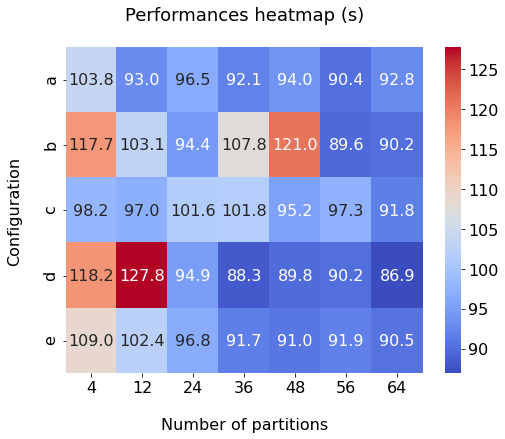

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
df = pd.DataFrame(heat, index = executors, columns = part)
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.1f', annot_kws={'fontsize':16}, ax=ax)
ax.set_title('Performances heatmap (s)\n', fontsize=18)
ax.set_xlabel('\nNumber of partitions', fontsize=16)
ax.set_ylabel('Configuration\n', fontsize=16)
plt.show()

***

**Code** | **Configuration** | **Memory**
:-:|:-:|:-:
a | 16 exe, each w/ 1 core | 1.5 Gb
b | 8 exe, each w/ 2 cores | 3 Gb
c | 3 exe, 1 w/ 4 cores, 2 w/ 2 cores | 6 Gb
d | 4 exe, each w/ 4 cores | 6 Gb
e | 3 exe, 1 w/ 8 cores, 2 w/ 4 cores | 6 Gb

<a id='6'></a>
[Index](#index)
### 6. Skimming and HLF creation

In [17]:
dfRoot.printSchema()

root
 |-- Electron_pfRelIso03_all: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- MET_phi: double (nullable = true)
 |-- MET_pt: double (nullable = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_pfRelIso03_all: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- event: long (nullable = true)
 |-- eventWeightLumi: double (nullable = true)
 |-- iSkim: long (nullable = true)
 |-- nBJet: long (nullable = true)
 |-- nCleanJet: long (nullable = true)
 |-- nElectron: long (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- sample: string (nullable = true)



#### First level filter

In [18]:
import pyspark.sql.functions as pf
import pyspark.sql.types as pt

arr = pt.ArrayType
maskMu = pf.udf(lambda iso, pt: [True if i < .15 and p > 15 else False for i,p in zip(iso,pt)], arr(pt.BooleanType()))
maskEl = pf.udf(lambda iso: [True if i < .15 else False for i in iso], arr(pt.BooleanType()))
apply_mask_long = pf.udf(lambda x, mask: [i for i,m in zip(x,mask) if m], arr(pt.LongType()))
apply_mask_doub = pf.udf(lambda x, mask: [i for i,m in zip(x,mask) if m], arr(pt.DoubleType()))
count_col = pf.udf(lambda m: abs(sum(m)), pt.IntegerType())
mass_mu = pf.lit(.1057)

In [19]:
def skimmer(df):
    fdf = df.filter('iSkim == 3')\
    .withColumn('maskMu', maskMu('Muon_pfRelIso03_all', 'Muon_pt'))\
    .withColumn('nGoodMu', count_col('maskMu'))\
    .withColumn('maskEl', maskEl('Electron_pfRelIso03_all'))\
    .drop('Muon_pfRelIso03_all', 'Electron_pfRelIso03_all')\
    .withColumn('nGoodEl', count_col('maskEl'))\
    .filter('(nGoodMu == 3) AND (nGoodEl == 0)')\
    .drop('nGoodMu', 'nGoodEl')\
    .withColumn('SumCharge', count_col(apply_mask_long('Muon_charge', 'maskMu')))\
    .filter('SumCharge != 3')\
    .drop('SumCharge')\
    .withColumn('sMuon_pt', apply_mask_doub('Muon_pt', 'maskMu'))\
    .withColumn('sMuon_eta', apply_mask_doub('Muon_eta', 'maskMu'))\
    .withColumn('sMuon_phi', apply_mask_doub('Muon_phi', 'maskMu'))\
    .withColumn('sMuon_charge', apply_mask_long('Muon_charge', 'maskMu'))\
    .withColumn('sMuon_mass', pf.array(mass_mu, mass_mu, mass_mu))\
    .drop('Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_charge')\
    .filter('(nCleanJet >= 2) AND (nBJet >= 1)')\
    .drop('nCleanJet', 'nBJet')
    
    return fdf

In [20]:
dfSkimmed = skimmer(dfRoot)

#### Second level filter: $\Delta R$, $\Delta\phi$ and $m_{inv}$

In [21]:
def DeltaR(eta1, eta2, phi1, phi2):
    return mh.sqrt((eta1-eta2)**2 + (phi1-phi2)**2)

@pf.udf(arr(pt.IntegerType()))
def find_idx(charge, phi, eta):
   
    idx = [-1]*len(charge)
    
    if(charge[0]==charge[1] and charge[1]!=charge[2]):
        idx[0] = 2
        dr_1 = DeltaR(eta[1], eta[2], phi[1], phi[2])
        dr_2 = DeltaR(eta[0], eta[2], phi[0], phi[2])
        
        if(dr_1 < dr_2): idx[1], idx[2] = 1, 0
        else: idx[1], idx[2] = 0, 1
        
    if(charge[0]!=charge[1] and charge[1]!=charge[2]): 
        idx[0] = 1
        dr_1 = DeltaR(eta[1], eta[2], phi[1], phi[2])
        dr_2 = DeltaR(eta[0], eta[1], phi[0], phi[1])
        
        if(dr_1 < dr_2): idx[1], idx[2] = 2, 0
        else: idx[1], idx[2] = 2, 0
    
    if(charge[0]!=charge[1] and charge[1]==charge[2]):
        idx[0] = 0
        dr_1 = DeltaR(eta[0], eta[2], phi[0], phi[2])
        dr_2 = DeltaR(eta[0], eta[1], phi[0], phi[1])
        
        if(dr_1 < dr_2): idx[1], idx[2] = 2, 1
        else: idx[1], idx[2] = 1, 2   
        
    return idx

In [22]:
dR = pf.udf(lambda eta1, eta2, phi1, phi2: DeltaR(eta1, eta2, phi1, phi2), pt.DoubleType())

return_value_long = pf.udf(lambda x,idx,val: x[idx[val]], pt.LongType())
return_value_doub = pf.udf(lambda x,idx,val: x[idx[val]], pt.DoubleType())

In [23]:
def invMass(pt, eta, phi, mass):
    
    size = len(pt)
    assert(len(eta) == size and len(phi) == size and len(mass) == size)
  
    x_sum, y_sum, z_sum, e_sum = 0., 0., 0., 0.
  
    for i in range(size):
        # Convert to (e, x, y, z) coordinate system and update sums
        x = pt[i] * mh.cos(phi[i])
        x_sum += x
        y = pt[i] * mh.sin(phi[i])
        y_sum += y
        z = pt[i] * mh.sinh(eta[i])
        z_sum += z
        e = mh.sqrt(x * x + y * y + z * z + mass[i] * mass[i])
        e_sum += e
        
    return mh.sqrt(e_sum * e_sum - x_sum * x_sum - y_sum * y_sum - z_sum * z_sum)

In [24]:
invMass3 = pf.udf(lambda pt, eta, phi, mass: invMass(pt, eta, phi, mass), pt.DoubleType())
invMass2 = pf.udf(lambda pt1, pt2, eta1, eta2, phi1, phi2, mass1, mass2:
                 invMass([pt1, pt2], [eta1, eta2], [phi1, phi2], [mass1, mass2]), pt.DoubleType())

In [25]:
def dfHLF(df):
    fdf = df.withColumn('mu_idx', find_idx('sMuon_charge', 'sMuon_phi', 'sMuon_eta'))\
    .withColumn('mu_pt0', return_value_doub('sMuon_pt', 'mu_idx', pf.lit(0)))\
    .withColumn('mu_pt1', return_value_doub('sMuon_pt', 'mu_idx', pf.lit(1)))\
    .withColumn('mu_pt2', return_value_doub('sMuon_pt', 'mu_idx', pf.lit(2)))\
    .withColumn('mu_eta0', return_value_doub('sMuon_eta', 'mu_idx', pf.lit(0)))\
    .withColumn('mu_eta1', return_value_doub('sMuon_eta', 'mu_idx', pf.lit(1)))\
    .withColumn('mu_eta2', return_value_doub('sMuon_eta', 'mu_idx', pf.lit(2)))\
    .withColumn('mu_phi0', return_value_doub('sMuon_phi', 'mu_idx', pf.lit(0)))\
    .withColumn('mu_phi1', return_value_doub('sMuon_phi', 'mu_idx', pf.lit(1)))\
    .withColumn('mu_phi2', return_value_doub('sMuon_phi', 'mu_idx', pf.lit(2)))\
    .withColumn('mu_q0', return_value_long('sMuon_charge', 'mu_idx', pf.lit(0)))\
    .withColumn('mu_q1', return_value_long('sMuon_charge', 'mu_idx', pf.lit(1)))\
    .withColumn('mu_q2', return_value_long('sMuon_charge', 'mu_idx', pf.lit(2)))\
    .withColumn('mu_mass0', pf.lit(0.1057))\
    .withColumn('mu_mass1', pf.lit(0.1057))\
    .withColumn('mu_mass2', pf.lit(0.1057))\
    .withColumn('inv_m3', invMass3('sMuon_pt', 'sMuon_eta', 'sMuon_phi', 'sMuon_mass'))\
    .withColumn('inv_m01', invMass2('mu_pt0', 'mu_pt1', 'mu_eta0', 'mu_eta1', 'mu_phi0', 'mu_phi1', 'mu_mass0', 'mu_mass1'))\
    .withColumn('inv_m02', invMass2('mu_pt0', 'mu_pt2', 'mu_eta0', 'mu_eta2', 'mu_phi0', 'mu_phi2', 'mu_mass0', 'mu_mass2'))\
    .withColumn('inv_m12', invMass2('mu_pt1', 'mu_pt2', 'mu_eta1', 'mu_eta2', 'mu_phi1', 'mu_phi2', 'mu_mass1', 'mu_mass2'))\
    .filter('(inv_m01 > 15) AND (inv_m02 > 15) AND (inv_m12 > 15)')\
    .filter('(abs(inv_m01 - 91.2) > 10) AND (abs(inv_m02 - 91.2) > 10)')\
    .withColumn('dR01', dR('mu_eta0', 'mu_eta1', 'mu_phi0', 'mu_phi1'))\
    .withColumn('dR02', dR('mu_eta0', 'mu_eta2', 'mu_phi0', 'mu_phi2'))\
    .withColumn('dPhi0', pf.abs(pf.col('MET_phi') - pf.col('mu_phi0')))\
    .withColumn('dPhi1', pf.abs(pf.col('MET_phi') - pf.col('mu_phi1')))\
    .withColumn('dPhi2', pf.abs(pf.col('MET_phi') - pf.col('mu_phi2')))
    
    return fdf

In [26]:
final = dfHLF(dfSkimmed)

<a id='7'></a>
[Index](#index)
### 7. Save the datasets as parquet files

In [27]:
final = final.cache()

In [28]:
dfFlat = final.drop('sMuon_pt','sMuon_eta','sMuon_phi','sMuon_charge','sMuon_mass','maskMu','maskEl','mu_idx',
                    'mu_mass0','mu_mass1','mu_mass2','mu_q0','mu_q1','mu_q2')

In [29]:
dfFlat.printSchema()

root
 |-- MET_phi: double (nullable = true)
 |-- MET_pt: double (nullable = true)
 |-- event: long (nullable = true)
 |-- eventWeightLumi: double (nullable = true)
 |-- iSkim: long (nullable = true)
 |-- nElectron: long (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- sample: string (nullable = true)
 |-- mu_pt0: double (nullable = true)
 |-- mu_pt1: double (nullable = true)
 |-- mu_pt2: double (nullable = true)
 |-- mu_eta0: double (nullable = true)
 |-- mu_eta1: double (nullable = true)
 |-- mu_eta2: double (nullable = true)
 |-- mu_phi0: double (nullable = true)
 |-- mu_phi1: double (nullable = true)
 |-- mu_phi2: double (nullable = true)
 |-- inv_m3: double (nullable = true)
 |-- inv_m01: double (nullable = true)
 |-- inv_m02: double (nullable = true)
 |-- inv_m12: double (nullable = true)
 |-- dR01: double (nullable = true)
 |-- dR02: double (nullable = true)
 |-- dPhi0: double (nullable = true)
 |-- dPhi1: double (nullable = true)
 |-- dPhi2: double (nullable = true)



In [30]:
DATASETS_PATH = './data'

%time dfFlat.write.parquet(DATASETS_PATH + '/flat_dataset', mode='overwrite')

CPU times: user 111 ms, sys: 39.6 ms, total: 150 ms
Wall time: 12min 56s


In [31]:
df = spark.read.format('parquet').load('./data/flat_dataset')

events = df.count()
print('There are {} events'.format(events))

There are 13791 events


In [32]:
df = df.cache()

<a id='8'></a>
[Index](#index)
### 8. Histograms plotting

In [33]:
def histo(variable, weight, sample, range_, bins):
    edges = np.array([i*(range_[1]-range_[0])/bins for i in range(0,bins+1)])
    edges = edges+range_[0]
    
    lim_couples = [[edges[i], edges[i+1]] for i in range(len(edges)-1)]
    
    def filtr(limits):
        if type(variable) != list:
            if (variable >= limits[0]) and (variable < limits[1]):
                return 1
            else: return 0
        else:
            lim0 = np.full(len(variable),limits[0])
            lim1 = np.full(len(variable),limits[1])
            mask = np.logical_and((variable >= lim0), (variable < lim1))
            if np.any(mask):
                return np.sum(mask)
            else: return 0
    
    counts = np.array(list(map(filtr, lim_couples))) * weight
    
    return (sample, [edges, counts])

In [34]:
def plot_histogram(data, variable, interval, nbins, compute=True, mu=0,
                   data_counts=None, SigMC_counts=None, bkgMC_counts=None):
    
    ### Histogram bins counting ###
    if compute:
        histos = dict(
            data.select([variable,'eventWeightLumi','sample']).rdd
            .map(lambda x: histo(x[variable], x['eventWeightLumi'], x['sample'], range_=interval, bins=nbins))
            .reduceByKey(lambda x,y: (x[0], x[1]+y[1])).take(50)
        )

        edges, data_counts = histos['data']                                                                              
        _ , SigMC_counts = histos['signal']

        bkgMC_counts = []
        bkgMC_labels = listBkgDir

        for value in bkgMC_labels:
            try:
                _ , counts = histos[value]
                bkgMC_counts.append(counts)
            except: continue
                
    if compute == False:
        edges = np.array([i*(interval[1]-interval[0])/nbins for i in range(0,nbins+1)])
        edges = edges+interval[0] 
    bin_centers = edges[:-1] + np.diff(edges)/2   
        
    ### Signal rescaling ###
    if mu == 0: 
        bkg_values, bkg_bins, _ = plt.hist(
            np.tile(bin_centers, (len(bkgMC_counts),1)).tolist(), weights=bkgMC_counts, bins=edges, 
            stacked=True, histtype= 'barstacked'
        )

        areaBkg = sum(np.diff(bkg_bins)*bkg_values)
        sig_values, sig_bins, _ = plt.hist(bin_centers, weights=SigMC_counts, bins=edges)
        areaSig = sum(np.diff(sig_bins)*sig_values) 
        mu = areaBkg/areaSig

        plt.close()
        
    else: SigMC_counts = SigMC_counts*mu + np.array(bkgMC_counts).sum(0)
    
    ### Background colors ###
    repeat = [1,4,1,1,15,3]
    colors = [(222/255, 90/255, 106/255),(248/255, 206/255, 104/255),(155/255, 152/255, 204/255),
                (247/255, 138/255, 221/255),(250/255, 202/255, 255/255),(100/255, 192/255, 232/255)]
    bkg_colors = [item for item, count in zip(colors, repeat) for i in range(count)]
    
    
    ### Plotting ###
    plt.figure(figsize=(8,5))

    plt.hist(
        np.tile(bin_centers, (len(bkgMC_counts),1)).tolist(), weights=bkgMC_counts, bins=edges,
        alpha=1., color=bkg_colors[:len(bkgMC_counts)], stacked=True, histtype= 'barstacked'
    )
                                                                                                  
    plt.errorbar(
        bin_centers, data_counts, yerr=np.sqrt(data_counts),
        fmt='o', ms=4, lw=1, color='black', label='Data', capsize=3
    )

    plt.hist(
        bin_centers, weights=SigMC_counts*mu, bins=edges,
        label='MCSig', color='#00A88F', alpha=1.,  histtype=u'step', linewidth=2
    )
                                                                                                
    plt.xlabel(variable, size=16)
    plt.ylabel('Counts', size=16)
    
    ST_patch = patches.Patch(color=bkg_colors[0], label='Single top')
    TT_patch = patches.Patch(color=bkg_colors[1], label='top top')
    TTW_patch = patches.Patch(color=bkg_colors[5], label=r'tt$\rightarrow$ W')
    TTZ_patch = patches.Patch(color=bkg_colors[6], label=r'tt$\rightarrow$ Z')
    Diboson_patch = patches.Patch(color=bkg_colors[7], label='Diboson')
    Others_patch = patches.Patch(color=bkg_colors[-1], label='Others')
    MCSig_patch = patches.Patch(color='#00A88F', label='FCNC')
    Data = Line2D([0], [0], marker='o', color='w', label='Data', markerfacecolor='black', markersize=7)

    plt.legend(handles=[ST_patch,TT_patch, TTW_patch, TTZ_patch, Diboson_patch, Others_patch, MCSig_patch, Data])
    plt.tight_layout()
    
    plt.show()
    
    return nbins, data_counts, SigMC_counts, bkgMC_counts


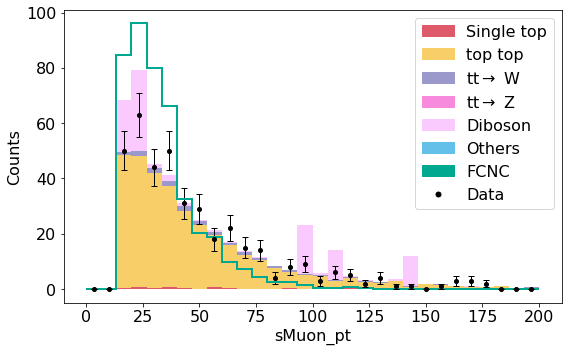

In [35]:
_, _, _, _ = plot_histogram(final, 'sMuon_pt', (0,200), 30)

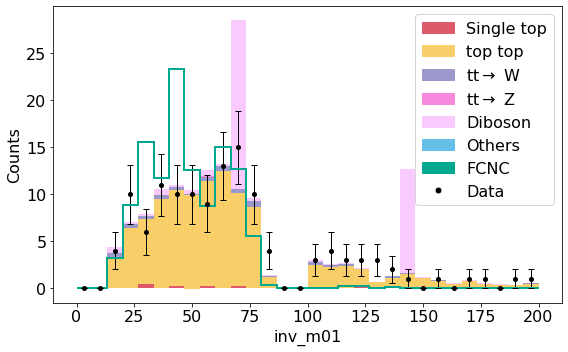

In [36]:
inv_m01_nbins, inv_m01_data, inv_m01_SigMC, inv_m01_bkgMC = plot_histogram(final, 'inv_m01', (0,200), 30)

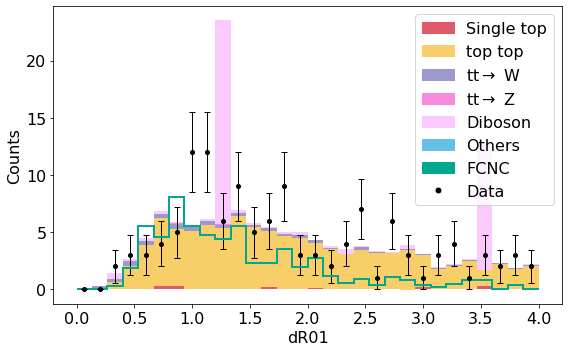

In [37]:
dR01_nbins, dR01_data, dR01_SigMC, dR01_bkgMC = plot_histogram(final, 'dR01', (0,4), 30)

In [38]:
nbins = inv_m01_nbins + dR01_nbins
data_count = np.concatenate((inv_m01_data, dR01_data))
SigMC_count = np.concatenate((inv_m01_SigMC, dR01_SigMC))
bkgMC_count = np.concatenate((np.array(inv_m01_bkgMC).sum(0), np.array(dR01_bkgMC).sum(0)))

<a id='9'></a>
[Index](#index)
### 9. Statistical analysis

In [39]:
import scipy as sp
from scipy.stats import poisson as ps

def like(x, mu_sig, bkg, mu_best):
    return np.prod(ps.pmf(x, mu_sig)), np.prod(ps.pmf(x, bkg)), np.prod(ps.pmf(x, mu_best))

In [40]:
def stat(nbin, data, sig, bkg):   
        
    mu_grid = np.arange(0, 3, 1e-3)
    
    b_plus_sig = np.outer(sig, mu_grid) + np.tile(bkg,(len(mu_grid),1)).T
    
    like_grid = np.prod(ps.pmf(np.tile(data,(len(mu_grid),1)).T, b_plus_sig), axis=0)
    mu_best = mu_grid[np.argmax(like_grid)]
    b_plus_sig_best = bkg + sig*mu_best
      
    ntoys = int(1e5)
    bin_toys = 100 
    
    mu_min = mu_best+1e-7
    mu_max = mu_best+3
    
    for i in range(30):
        mu = (mu_min+mu_max)/2
        
        b_plus_sig_mu = bkg + sig*mu
        
        toys = sc.parallelize(np.tile(b_plus_sig_mu, (ntoys,1))).map(lambda x: ps.rvs(x))
        
        like_tot = toys.map(lambda x: like(x, b_plus_sig_mu, bkg, b_plus_sig_best))
        
        q_mu = np.array(like_tot.map(lambda x: (-2*np.log(x[1]/x[2]), -2*np.log(x[0]/x[2]))).take(ntoys))
        q_mu0 = q_mu[:,0]
        q_mu1 = q_mu[:,1]
        
        like_num_obs = np.prod(ps.pmf(data, b_plus_sig_mu))
        like_den_obs = np.prod(ps.pmf(data, b_plus_sig_best))
        q_mu_obs = -2 * np.log(like_num_obs/like_den_obs)
        
        ### H0 ###
        values_0, bins_0, _ = plt.hist(q_mu0, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_0 > q_mu_obs)
        p_b = sum(np.diff(bins_0[mask])*values_0[mask[:-1]])
        
        ### H1 ###
        values_1, bins_1, _ = plt.hist(q_mu1, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_1 > q_mu_obs)
        p_mu = sum(np.diff(bins_1[mask])*values_1[mask[:-1]])
        
        if p_b == 0:
            mu_max = mu
            continue
        
        CL = p_mu/p_b
        
        if CL < 0.05: mu_max = mu
        else: mu_min = mu
    
    plt.figure(figsize=(8, 5))
    plt.hist(q_mu0, bins=bin_toys, alpha=0.5, color='red', density=True, label='$H_0$')
    plt.hist(q_mu1, bins=bin_toys, alpha=0.5, color='blue', density=True, label='$H_1$')
    plt.ylim((0,0.15))
    plt.axvline(q_mu_obs, color='#00A88F', label='$q^{obs}(\mu)$')
    plt.title(r'Distributions of $q(\mu)_0$ and $q(\mu)_1$')
    plt.xlabel(r'$q(\mu)$', size=16)
    plt.legend(frameon=False)
    plt.show()
            
    significance = -sp.stats.norm.ppf(p_b)
        
    return mu, mu_best, CL, significance

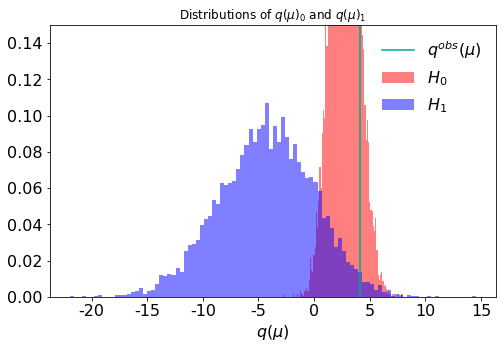

In [41]:
mustar, mu_hat, CL, signif = stat(nbins, data_count, SigMC_count, bkgMC_count)

In [42]:
print('mu limit:', round(mustar,3))

mu limit: 3.784


<a id='10'></a>
[Index](#index)
### 10. Final results

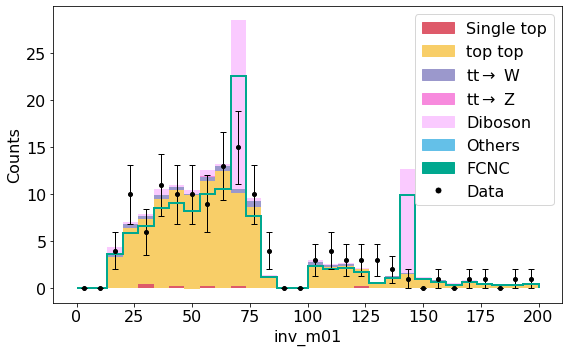

In [43]:
_, _, _, _ = plot_histogram(final, 'inv_m01', (0,200), 30, compute=False, mu=mu_hat,
                            data_counts=inv_m01_data, SigMC_counts=inv_m01_SigMC, bkgMC_counts=inv_m01_bkgMC)

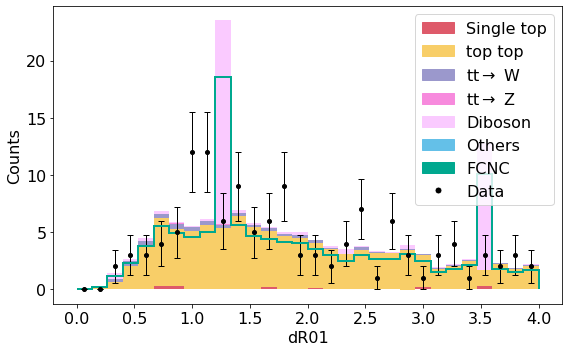

In [44]:
_, _, _, _ = plot_histogram(final, 'dR01', (0,4), 30, compute=False, mu=mu_hat,
                            data_counts=dR01_data, SigMC_counts=dR01_SigMC,
                            bkgMC_counts=dR01_bkgMC)

#### Stop Spark context

In [45]:
sc.stop()
spark.stop()